# Machine Learning for Textual Data - The Bible and other religious texts
<b> Advanced Numberical Methods and Data Analysis - University of St. Gallen (HSG) - Spring semester 2019 </b>

Elisa Fleissner       (14-350-608)

Lars Stauffenegger    (tbd)

Alexander Steeb       (tbd)

05.05.2019

--------------------------------------------------------------------------------------------

## Project plan and structure

In this project we analyse the bible text and other religious texts using machine learning for textual data. From this analysis we expect to see different relevant topics and contexts between the books of the bible and between the different religious texts.

This analysis is structures as follows: In a first step, a thorough analysis of the bible is done to understand different topics within the books and to see a development of the topics over time. We expect to see that certain topics where clearly more relevant in the old testament and the new testament. For the topic analysis in this section, we will use the Latent Dirichlet Allocation (LDA) and the Word2Vec algorithm is used to understand the context of certain words. This allows to capture differences in the perception of one specific word in the old. vs new testament.
In a second part we will then include other religious texts such as the Qu'aran and others. We will perform an anlysis over **five** texts to find similarities and patterns ...

### PART I: The Bible ###
- Before starting with the analysis and data import, we need to first setup helpers function and import all relevant libraries used for this project. 
- Then we are importing the data and assigning the correct names of the books to the texts as well as the testament (old or new). 
- We then have to process the data to make it suitable for the machine learning algorithm. We achieve this by defining several formulas including preprocessing, stopword removal, tokenization, lemmatization and stemming.
- When the data is ready, the actual analysis can be performed

### PART II: 5 religious texts ###
- The imported functions and cleaning steps can be used from PART I, however, we need to import all texts and bring them to the same format (i.e. no separation between the different books)
- Cleaning of the data using the functions from PART I
- Analysis

## 0. Setup

In [60]:
# import functions
import json
import os
import shutil
import sys

import requests, zipfile, io

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob, Word

import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import word2vec

In [61]:
# Option to display whole text and not only first few words
pd.set_option('display.max_colwidth', 1)

In [62]:
print(sys.executable)
print(sys.version)

/anaconda3/bin/python
3.7.1 (default, Dec 14 2018, 13:28:58) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


# PART I: The Bible

## Preparation
### TextBlob
It is important to install textblob correctly and to download the corpora. Source: https://textblob.readthedocs.io/en/dev/


```
pip install -U textblob
python -m textblob.download_corpora
```

### Helper functions

In [182]:
# Remove existing folder
# based on: https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty-with-python
def remove_folder(path):
    # check if folder exists
    if os.path.exists(path):
         # remove if exists
         shutil.rmtree(path)
    else:
         # throw your exception to handle this special scenario
         print('Folder does not exist')

# Get one text string instead of separated text bits
def gen_full_text(texts):
    full_text = ''
    for text in texts:
        full_text += text
    return(full_text)

# Helper function to get the digits in one text
def get_num(text):
    return(int(''.join([n for n in text if n.isdigit()])))

# Stopwords
custom_stopwords = stopwords.words('english')
custom_stopwords.extend(["nephi","alma","mormoni","ether", "say", "let", "may", "give", 
                         "make", "come", "go", "take", "put", "an", "er"])

## 1. Data import

In this section we will import the bible data. Particular caution has to be paid to the correct specification of the different books and the old/new testamnet as this is crucial for the following LDA analysis.

Data source: https://sites.google.com/site/ruwach/bibletext

In [183]:
remove_folder("data")

In [184]:
old_zip_file_url = "https://sites.google.com/site/ruwach/Basic_English_OldTestament.zip?attredirects=0"
#old_zip_file_url = "http://ruwach.googlepages.com/OldTestament.zip"

new_zip_file_url = "https://sites.google.com/site/ruwach/Basic_English_NewTestament.zip?attredirects=0"
#new_zip_file_url = "http://ruwach.googlepages.com/NewTestament.zip"
    
def unzip(url):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("data/")
    
unzip(old_zip_file_url)
unzip(new_zip_file_url)

In [185]:
path = "data"
df = pd.DataFrame()  

testaments = os.listdir(path)

for testament in testaments:
    testament_path = os.path.join(path,testament)
    books = os.listdir(testament_path)
    
    for book in books:
        book_path = os.path.join(testament_path,book)
        files = os.listdir(book_path)    
            
        for file in files:
            file_path = os.path.join(book_path,file) 
            
            with open(file_path, "r", encoding = "utf-8") as infile:
                text = infile.read()
                df = df.append([[text, testament, book, file, file_path]], ignore_index=True)
                
df.columns = ["text", "testament", "book", "file", "path"]

In [186]:
books = (
    "Genesis",
    "Exodus",
    "Leviticus",
    "Numbers",
    "Deuteronomy",
    "Joshua",
    "Judges",
    "Ruth",
    "1 Samuel",
    "2 Samuel",
    "1 Kings",
    "2 Kings",
    "1 Chronicles",
    "2 Chronicles",
    "Ezra",
    "Nehemiah",
    "Esther",
    "Job",
    "Psalms",
    "Proverbs",
    "Ecclesiastes",
    "Song of Solomon",
    "Isaiah",
    "Jeremiah",
    "Lamentations",
    "Ezekiel",
    "Daniel",
    "Hosea",
    "Joel",
    "Amos",
    "Obadiah",
    "Jonah",
    "Micah",
    "Nahum",
    "Habbakuk",
    "Zephaniah",
    "Haggai",
    "Zechariah",
    "Malachi",
    "Matthew",
    "Mark",
    "Luke",
    "John",
    "Acts",
    "Romans",
    "1 Corinthians",
    "2 Corinthians",
    "Galatians",
    "Ephesians",
    "Philippians",
    "Colossians",
    "1 Thessalonians",
    "2 Thessalonians",
    "1 Timothy",
    "2 Timothy",
    "Titus",
    "Philemon",
    "Hebrews",
    "James",
    "1-2 Peter",
    "1-3 John",
    "Jude",
    "Revalation")

In [187]:
# Order the books
books_order = pd.DataFrame.from_records(zip(books, range(1,len(books))))
books_order.columns = ["book", "order"]

# Merge the book information to the downloaded text
df = pd.merge(df,books_order, on ='book')

In [188]:
df['file'] = df['file'].apply(get_num)

In [189]:
df = df.sort_values(["order", "file"], ascending = [True, True])
df.reset_index(drop = True, inplace = True)

## 2. Data cleaning

In this section we will prepare the data to be analysed. We therefore need to apply different techniques to clean the data so that machine learning algorithms can analyse the data set. For a first inspection of the data, we will use a wordcloud and word count analysis.

The following steps are part of the preprocessing phase to make the text ready for the algorithms (https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34)

**Tools:** 
1. Preprocessor
    - Only keep latin characters
    - Change all the text to lower case
    - Remove line breaks
    - Tokenization
2. Lemmatizer
3. Remove Stop words
4. Wordcloud text processor

In [190]:
def preprocessor(t):
    '''Prepare text from TextBlob'''
    # Regex to remove roman numerals / source: https://stackoverflow.com/questions/267399/how-do-you-match-only-valid-roman-numerals-with-a-regular-expression
    t = re.sub(r'(?=\b[MCDXLVI]{1,6}\b)M{0,4}(?:CM|CD|D?C{0,3})(?:XC|XL|L?X{0,3})(?:IX|IV|V?I{0,3})', ' ', t)
    t = t.lower() 
    t = t.replace('\n', ' ') # Replace newline with space
    t = re.sub('[^a-zA-Z]',' ',t)
    return t.strip()


# inspired by https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def lemmatizer(text):
    text = TextBlob(text)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}

    result = ' '
    
    for sentence in text.sentences:
        words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sentence.tags]
        lemmatized_list = [w.lemmatize(tag) for w, tag in words_and_tags]
        sentence_new = ' '.join(lemmatized_list)
        result += sentence_new
    return(str(result))

def remove_stopwords(text):
    text = TextBlob(text)
    text = (token for token in text.tokens if token not in custom_stopwords)
    stopremoved = ' '.join(text)
    return(str(stopremoved))

def wordcloud_map(text_corp):
    full_text = ''
    for text in text_corp:
        full_text += text          
    wordcloud = WordCloud(max_font_size = 40,background_color = "white").generate(full_text)

    plt.figure(figsize = (10,10))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

In [191]:
%%time
df['clean'] = df['text']
df['clean'] = df['clean'].apply(preprocessor)
df['clean'] = df['clean'].apply(lemmatizer)

CPU times: user 40.3 s, sys: 97.1 ms, total: 40.4 s
Wall time: 40.5 s


In [192]:
%%time
df['clean_rm'] = df['clean'].apply(remove_stopwords)

CPU times: user 4.85 s, sys: 7.04 ms, total: 4.86 s
Wall time: 4.86 s


## 3. Data inspection
In this section we will conduct some simple analysis of the processed data to better understand the most frequent words. We will use a wordcloud ...

### Wordcloud

The wordcloud is used to display the frequency of the words by size. This is a suitable tool for to get a first glimpse of the texts to be analysed.

We conduct this analysis for
- the entire bible
- the old testament
- the new testament

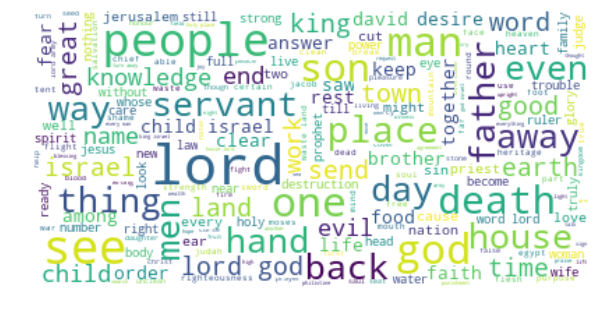

In [193]:
# Entire bible
wordcloud_map(df['clean_rm'])

Old Testament


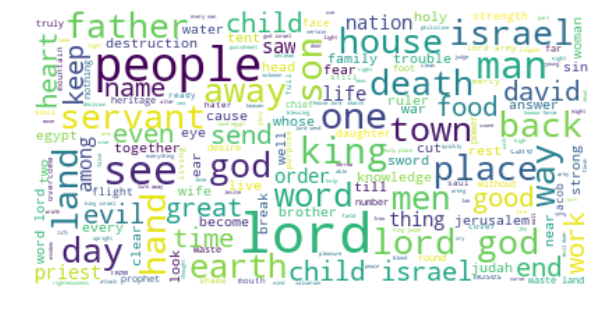

In [194]:
# Old testament only
i = 0
print(testaments[i])

data = df.loc[df.testament == testaments[i],'clean_rm']
wordcloud_map(data)

New Testament


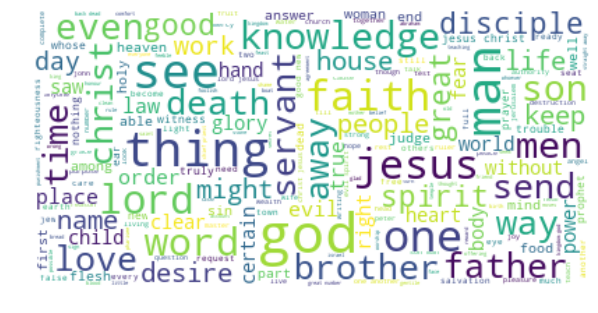

In [195]:
# New testament only
i = 1
print(testaments[i])

data = df.loc[df.testament == testaments[i],'clean_rm']
wordcloud_map(data)

### Term frequency
In this analysis we will compare the word frequency of the entire bible to the old and new testament.

In [196]:
# We define a function for the word count and plotting
def word_count(text):
    full_text = ''
    for words in text:
        full_text += words
    
    # Split the string into words
    words = full_text.split()

    # Define minimum length
    len([words for words in words if len(words) > 5])

    # Calculate and plot the word frequency
    fd = nltk.FreqDist(words)
    fd.plot(30, cumulative = False)

Entire bible


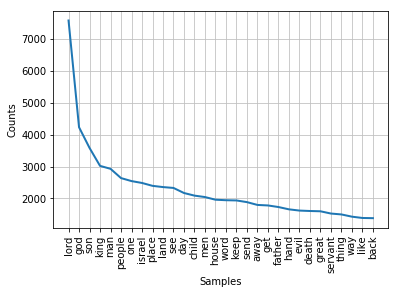

Old testament


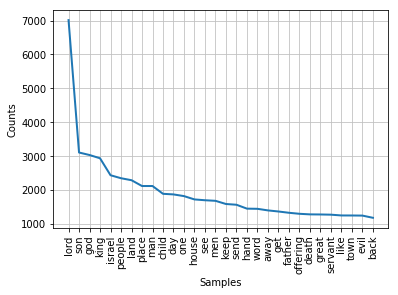

New testament


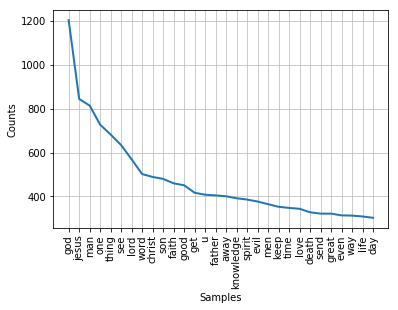

In [197]:
# Calling the function and plotting the results
print("Entire bible")  
text = df["clean_rm"]
word_count(text)

print("Old testament")
text = df.loc[df.testament == "Old Testament", "clean_rm"]
word_count(text)

print("New testament")
text = df.loc[df.testament == "New Testament", "clean_rm"]
word_count(text)

## 4. Model 1 - LDA

### Description of the model
Latent Dirichlet Allocation (LDA) is a method to identify topics within a text corpus. This model has been developed by [Blei, Ng and Jordan (2003)](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) and is based on a three-level hierarchical Bayesian model and the Dirichlet distribution. 
We will use this method for a preliminary analysis on our bible texts to see whether the topics discussed in the books have been changing over time. We expect to see that over the time (over the evolvement of the different books), the topics have changed significantly. An interesting change will probably also be observed for the beginning of the new testament.
We got inspiration for this code from Knoepfl, Rieger & Sommer (2018).

### Estimation 1: Topic identification and wordcloud representation
In this step, the LDA model is used to identify the different topics and output the words around each topic as a wordcloud.

In [198]:
# Choose the number of topics that should be identified
n_components = 4

In [199]:
# Get the text
text = df['clean_rm']

# Vectorize the text
count = CountVectorizer(
            min_df = 2,
            max_df = 0.90,
            ngram_range = (1,3)
            )

txt_count = count.fit_transform(text)
txt_count

<1136x60963 sparse matrix of type '<class 'numpy.int64'>'
	with 352585 stored elements in Compressed Sparse Row format>

In [200]:
# Fit LDA model
lda = LatentDirichletAllocation(
    n_components = n_components, 
    random_state = 123, 
    learning_method = 'batch',
    max_iter = 50,
    verbose = False,
    evaluate_every = True)

X_topics = lda.fit_transform(txt_count)
lda.components_.shape

(4, 60963)

In [209]:
# Print most important words of every topic
print("The most important words of our four topics are:")

n_top_words = 5
feature_names = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print()
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
    for i in topic.argsort()\
        [:-n_top_words - 1:-1]]))    

The most important words of our four topics are:

Topic 1:
lord god man land people

Topic 2:
son lord israel king offering

Topic 3:
god king lord thing word

Topic 4:
man jesus see one god


### Estimation 2: Evolvement over time
In this step we will plot the different topics identified in step 1 over the development of the bible (the books).

In [202]:

X_topics = pd.DataFrame(X_topics)

X_topics['order'] = df['order']

X_topics_mean = X_topics.groupby(df['book']).mean()

X_topics_mean = X_topics_mean.sort_values('order', )
df.reset_index(drop=True, inplace=True)

X_topics_mean =X_topics_mean.iloc[:,0:n_components]

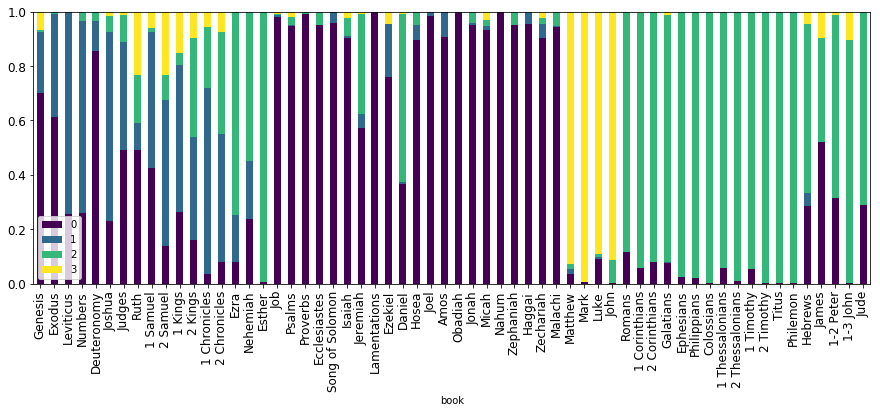

In [203]:
X_topics_mean.plot(kind='bar',
                   stacked=True,
                   rot='vertical',
                   ylim=(0,1),
                   figsize=(15, 5), 
                   legend=True, 
                   fontsize=12,
                   colormap = "viridis"
                  )

## 5. Model 2 - Word2vec

As a second model we would like to present the Word2vec model, which allows for contextual analysis. The model has been introduced by [Mikolov et al.](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). The word2vec method allows to reconstruct linguistic features of the corpus analysed and embedds the words in their context using a shallow two-layer network. This method allows to evaluate the associations to a certain word and thus allows to capture the sentiment of the text. Inspiration for this part has been obtained [here](https://nbviewer.jupyter.org/github/danielfrg/word2vec/blob/master/examples/word2vec.ipynb). 

Using this method, we can detect different word associations within the different parts of the bible. We expect for example, that the word *"god"* could be embedded differently in the old than in the new testament.

**TODO**

- z.B. was wird mit Gott im alten vs neune Testament verbunden etc. / Gott steht zu Jesus im Verhältnis wie ....
- Visualization of results

### Model estimation

In [204]:
# Preparation
remove_folder("model")
os.mkdir("model")

In [205]:
# Open all three text files (full text, old and new testament)

with open("model/text_full.txt", "w") as text_file:
    text_file.write(gen_full_text(df.loc[:,'clean']))
    
with open("model/text_old.txt", "w") as text_file:
    text_file.write(gen_full_text(df.loc[df['testament'] == testaments[0],'clean']))

with open("model/text_new.txt", "w") as text_file:
    text_file.write(gen_full_text(df.loc[df['testament'] == testaments[1],'clean']))

In [206]:
# Write a function to estimate the word2vec model
def estimate_word2vec(file):
    word2vec.word2phrase(train = file, 
                     output = "model/text-phrases", 
                     min_count = 1,
                     verbose = True)
    word2vec.word2vec("model/text-phrases", "model/text.bin", 
                  size = 100, 
                  min_count = 2,
                  # sample = 1e-5, # Downsample high frequenzy words
                  verbose = True)
    return(word2vec.load('model/text.bin'))

In [208]:
# Estimate all three models and print the progress

print("Fit full model")
model_full = estimate_word2vec('model/text_full.txt')

print('\n')
print("Fit old testament model")
model_old = estimate_word2vec('model/text_old.txt')

print('\n')
print("Fit new testament model")
model_new = estimate_word2vec('model/text_new.txt')

Fit full model
Starting training using file model/text_full.txt
Words processed: 700K     Vocab size: 82K  
Vocab size (unigrams + bigrams): 90004
Words in train file: 799828
Starting training using file model/text-phrases
Vocab size: 4630
Words in train file: 782028
Alpha: 0.000002  Progress: 100.60%  Words/thread/sec: 385.87k  5%  Words/thread/sec: 351.55k  ress: 15.35%  Words/thread/sec: 364.41k  876  Progress: 20.76%  Words/thread/sec: 368.66k  ha: 0.018744  Progress: 25.29%  Words/thread/sec: 382.76k  57k  sec: 376.59k  s/thread/sec: 378.99k  68%  Words/thread/sec: 379.85k  ress: 47.99%  Words/thread/sec: 382.80k  a: 0.010898  Progress: 56.70%  Words/thread/sec: 381.61k   Words/thread/sec: 380.55k  lpha: 0.001779  Progress: 93.18%  Words/thread/sec: 380.63k  

Fit old testament model
Starting training using file model/text_old.txt
Words processed: 600K     Vocab size: 75K  
Vocab size (unigrams + bigrams): 78622
Words in train file: 638749
Starting training using file model/text-p

### Similarity analysis

In [242]:
# Set a token for which similar words should be found
token = "god"

# For entire bible text
indexes, metrics = model_full.similar(token)
model_f = model_full.generate_response(indexes, metrics).tolist()

# For old testament
indexes, metrics = model_old.similar(token)
model_o = model_old.generate_response(indexes, metrics).tolist()

# For new testament
indexes, metrics = model_new.similar(token)
model_n = model_new.generate_response(indexes, metrics).tolist()

# Print results
print("Entire bible")
print(model_f)

print("Old testament")
print(model_o)

print("New testament")
print(model_n)

Entire bible
[('lord', 0.7408725171954492), ('grace', 0.7299075513834203), ('salvation', 0.7272111212221695), ('glory', 0.7237798055977366), ('good_news', 0.6648000964614769), ('praise', 0.6631069053653286), ('righteousness', 0.660377629759928), ('witness', 0.6595646488171046), ('jesus_christ', 0.6586875262161762), ('hope', 0.6527914007087664)]
Old testament
[('lord', 0.764647664006624), ('judge', 0.7352550460031766), ('prayer', 0.7315035986906013), ('salvation', 0.7311115688647275), ('praise', 0.7165985003500592), ('blessing', 0.6945130998819522), ('decision', 0.6872686943821908), ('worship', 0.6847994990167701), ('mercy', 0.6838189282973596), ('grace', 0.6635205062132083)]
New testament
[('christ', 0.9764036782105054), ('our', 0.9748715258373528), ('law', 0.9619806091756254), ('glory', 0.9603808152014444), ('father', 0.9602605686190153), ('grace', 0.9464390871703742), ('spirit', 0.94280912696844), ('flesh', 0.9423220993821908), ('through', 0.9385527202061164), ('thing', 0.93786282645

Entire bible - Related words to -> god


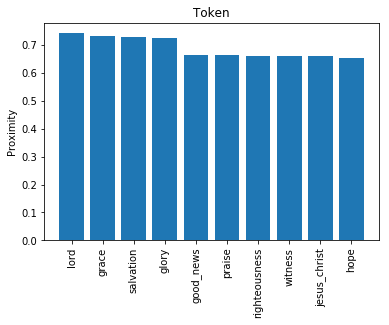

Entire bible - Related words to -> god


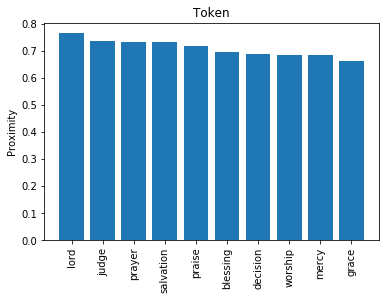

New testament - Related words to -> god


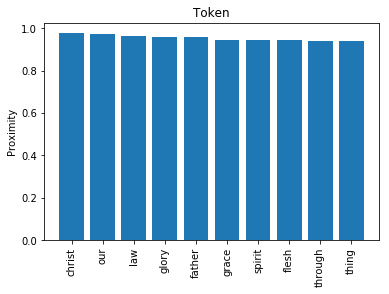

In [243]:
def plot_word2vec(model):
    plot_df = pd.DataFrame(model)
    xpos = np.arange(len(plot_df))
    performance = plot_df.loc[:, 1]

    plt.bar(xpos, performance, align = 'center')
    plt.ylabel('Proximity')
    plt.title('Token')
    plt.xticks(xpos, plot_df.loc[:, 0])
    plt.xticks(rotation = 90)
    plt.show()

# Entire bible
print("Entire bible - Related words to ->",token)
plot_word2vec(model_f)

# Old testament
print("Entire bible - Related words to ->",token)
plot_word2vec(model_o)

# New
print("New testament - Related words to ->",token)
plot_word2vec(model_n)

In [244]:
# Another token
token2 = "jesus"

indexes, metrics = model_full.similar(token2)
model_full.generate_response(indexes, metrics).tolist()

[('peter', 0.8628066023248416),
 ('john', 0.8244989645567827),
 ('disciple', 0.8099956506585944),
 ('pharisee', 0.8089430431138334),
 ('elijah', 0.7839656523333571),
 ('here', 0.7425929677159822),
 ('talk', 0.727401351414657),
 ('baptism', 0.7087372566339405),
 ('pilate', 0.6932198189247821),
 ('nazarene_jesus', 0.6873270896325907)]

### Analogies
This allows to construct the king - man + women = queen analogy.

In [248]:
indexes, metrics = model_full.analogy(pos = ['moses', 'israel'], neg = ['man'])
model_full.generate_response(indexes, metrics).tolist()

[('joshua', 0.46235588139623207),
 ('meeting', 0.41773450064024464),
 ('judah', 0.3908085666760517),
 ('ammon', 0.38704273243564324),
 ('tent', 0.35577434614004),
 ('assyria', 0.35247565253431906),
 ('order', 0.35083674199389936),
 ('levite', 0.3489137836116196),
 ('aaron', 0.34476169085601205),
 ('ark', 0.3426867687137019)]

## 6. Sentiment
In this section we analyse the sentiments of each book of the bible.

In [249]:
# Calculate the sentiment and group in data frame
df['sentiment'] = df.text.apply(lambda x: TextBlob(str(x)).sentiment.polarity)
sentiment = df[['sentiment','order']].groupby(df['book']).mean()
sentiment = sentiment.sort_values('order', )
#df.reset_index(drop=True, inplace=True)
sentiment = sentiment.iloc[:,[0]]

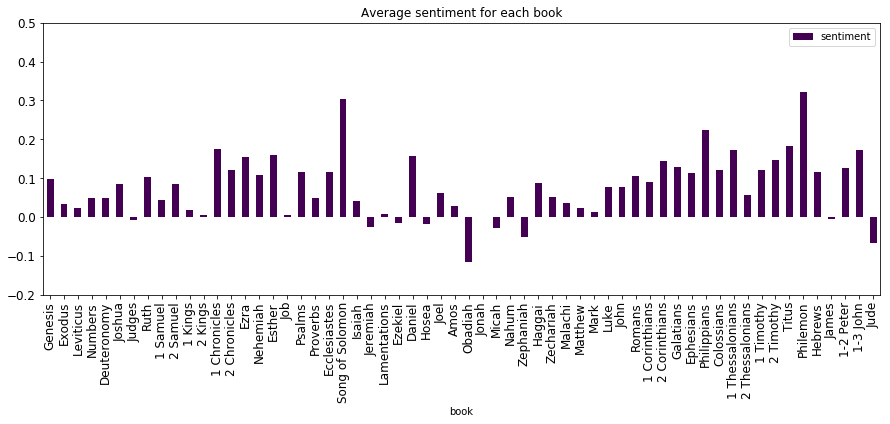

In [250]:
# Plot the sentiment
sentiment.plot(kind = 'bar',
                   rot = 'vertical',
                   ylim = (-0.2,0.5),
                   title = 'Average sentiment for each book',
                   figsize = (15, 5), 
                   legend = True, 
                   fontsize = 12,
                   colormap = "viridis"
                  )

# PART II: Comparison of religious texts
In this second part of our project we focus not only on the bible but on five different religious books. We obtained the books from [Kaggle](https://www.kaggle.com/tentotheminus9/religious-and-philosophical-texts). The following texts are analysed
- The King James Bible
- The Quran
- The Book Of Mormon
- The Gospel of Buddha
- Meditations, by Marcus Aurelius

## 1. Import all texts

In [255]:
# Prepare the paths for importing
path = "texts"
df_books = pd.DataFrame() 

books = os.listdir(path)
books

['Meditations.txt', 'Mormon.txt', 'Bible.txt', 'Koran.txt', 'Buddha.txt']

In [256]:
# Prepare the paths to each file
book_list = list()

for book in books:
    book_path = os.path.join(path,book)
    print(book_path)
    with open(book_path, "r", encoding = "utf-8") as infile:
        raw_text = infile.read()
        book_list.append(raw_text)
        #df_books = df_books.append([[book, raw_text, book_path]], ignore_index=True)

texts/Meditations.txt
texts/Mormon.txt
texts/Bible.txt
texts/Koran.txt
texts/Buddha.txt


In [257]:
# Open the book and apply the cleaning processes
book_path = os.path.join(path, books[0])
print(book_path)

with open(book_path, "r", encoding="utf-8") as infile:
        raw_text = infile.read()
        meditations = TextBlob(raw_text)        

start = meditations.find("MARCUS AURELIUS ANTONINUS was born on April 26")
end = meditations.find("THIS being neither a critical edition of the text")
meditations = meditations[start:end]

meditations_clean = meditations.raw
meditations_clean = preprocessor(meditations_clean)
meditations_clean = lemmatizer(meditations_clean)
meditations_clean = remove_stopwords(meditations_clean)

texts/Meditations.txt


In [258]:
# Open the book and apply the cleaning processes
book_path = os.path.join(path,books[1])
print(book_path)

with open(book_path, "r", encoding="utf-8") as infile:
        raw_text = infile.read()
        mormon = TextBlob(raw_text)        

start = mormon.find("THE BOOK OF MORMON")
end = mormon.find("End of the Project Gutenberg EBook of The Book Of Mormon, by Anonymous")
mormon = mormon[start:end]

mormon_clean = mormon.raw
mormon_clean = preprocessor(mormon_clean)
mormon_clean = lemmatizer(mormon_clean)
mormon_clean = remove_stopwords(mormon_clean)

texts/Mormon.txt


In [259]:
# Open the book and apply the cleaning processes
book_path = os.path.join(path,books[3])
print(book_path)

with open(book_path, "r", encoding="utf-8") as infile:
        raw_text = infile.read()
        koran = TextBlob(raw_text)        

start = koran.find("SURA1 XCVI.-THICK BLOOD, OR CLOTS OF BLOOD [I.]")
end = koran.find("End of The Project Gutenberg Etext of The Koran")
koran = koran[start:end]

koran_clean = koran.raw
koran_clean = preprocessor(koran_clean)
koran_clean = lemmatizer(koran_clean)
koran_clean = remove_stopwords(koran_clean)

texts/Koran.txt


In [260]:
# Open the book and apply the cleaning processes
book_path = os.path.join(path,books[4])
print(book_path)

with open(book_path, "r", encoding="utf-8") as infile:
        raw_text = infile.read()
        buddha = TextBlob(raw_text)        

start = buddha.find("Rejoice at the glad tidings!")
end = buddha.find("TABLE OF REFERENCE.")
buddha = buddha[start:end]

buddha_clean = buddha.raw
buddha_clean = preprocessor(buddha_clean)
buddha_clean = lemmatizer(buddha_clean)
buddha_clean = remove_stopwords(buddha_clean)

texts/Buddha.txt


In [261]:
# We use the bible text from PART I
bible_clean = gen_full_text(df['clean_rm'])

# 2. LDA analysis

In [262]:
# Choose the number of topics that should be identified
n_components = 4

In [263]:
all_texts = pd.DataFrame([['Bible', bible_clean],
                    ['Meditations', meditations_clean],
                    ['Mormon', mormon_clean],
                    ['Koran', koran_clean],
                    ['Buddha', buddha_clean]])

all_texts.columns = ["book", "text"]

In [264]:
text = [text for text in all_texts['text']]

In [265]:
count = CountVectorizer(
            min_df = 2,
            max_df = 0.95,
            ngram_range = (1,3)
            )

txt_count = count.fit_transform(text)
txt_count

<5x25316 sparse matrix of type '<class 'numpy.int64'>'
	with 57695 stored elements in Compressed Sparse Row format>

In [266]:
# Fit LDA model
lda = LatentDirichletAllocation(
    n_components = n_components, 
    random_state = 123, 
    learning_method = 'batch',
    max_iter = 50,
    verbose = False,
    evaluate_every = True)

X_topics = lda.fit_transform(txt_count)

lda.components_.shape

(4, 25316)

In [267]:
# Print most important words of every topic
print("The most important words of our four topics are:")

n_top_words = 5
feature_names = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print()
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
    for i in topic.argsort()\
        [:-n_top_words - 1:-1]]))    


The most important words of our four topics are:

Topic 1:
unto shall ye behold pass

Topic 2:
shall ye thou hath thee

Topic 3:
israel offering david lord god jesus

Topic 4:
part king son far child husband good profit see old


In [268]:
X_topics = pd.DataFrame(X_topics)
X_topics.index = all_texts['book']

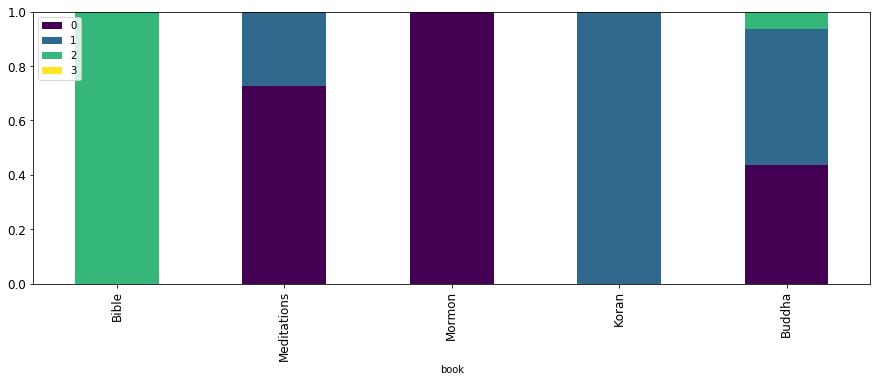

In [269]:
X_topics.plot(kind='bar',
                   stacked=True,
                   rot='vertical',
                   ylim=(0,1),
                   figsize=(15, 5), 
                   legend=True, 
                   fontsize=12,
                   colormap = "viridis"
                  )

# 3. Sentiment

In [75]:
all_texts['sentiment'] = all_texts.text.apply(lambda x: TextBlob(str(x)).sentiment.polarity)

sentiment = all_texts[['book','sentiment']].groupby(['book']).mean()

<Figure size 432x288 with 0 Axes>

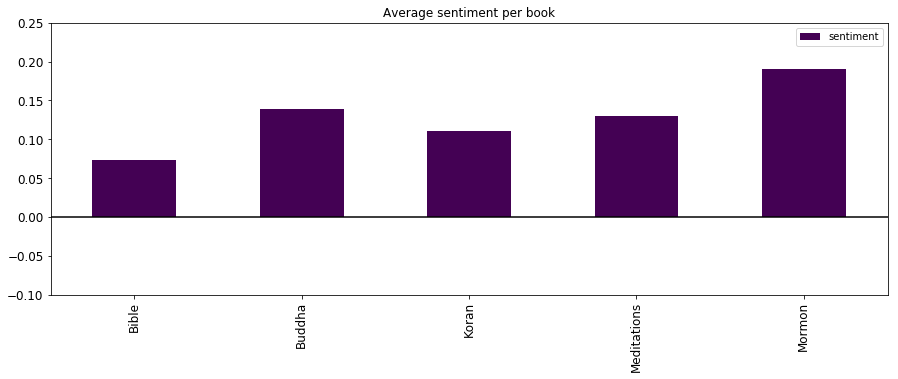

In [76]:
plt.figure();

ax = sentiment.plot(kind='bar',
                   rot='vertical',
                    title = "Average sentiment per book",
                   ylim=(-0.1,0.25),
                   figsize=(15, 5), 
                   legend=True, 
                   fontsize=12,
                   colormap = "viridis"
                  )

ax.set_xlabel("")

plt.axhline(0, color='k')